<a href="https://colab.research.google.com/github/srujayreddyv/CSC177-P2-LinearRegressionProject/blob/main/CSC177_P2_PartB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC177- Project 2 Part B
# Data Preprocessing Project (Fall 2023)

## Team Challengers (23):
  1. Srujay Reddy Vangoor
  2. Vaibhav Jain
  3. Bashar Allwza
  4. Varun Bailapudi
  5. Uddayankith Chodagam

## Loading function definations and libraries

In [ ]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.4f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low


## Loading the dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression.csv to Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression.csv


In [ ]:
# Dataset can be found here : https://www.kaggle.com/datasets/budincsevity/szeged-weather
df = pd.read_csv('Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
df.shape

(500, 9)

# Part B

In [ ]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}") # 80%
print(f"No. of testing examples: {testing_data.shape[0]}")  # 20%

No. of training examples: 400
No. of testing examples: 100


## Simple Linear Regresssion Model

Error: 0.0038


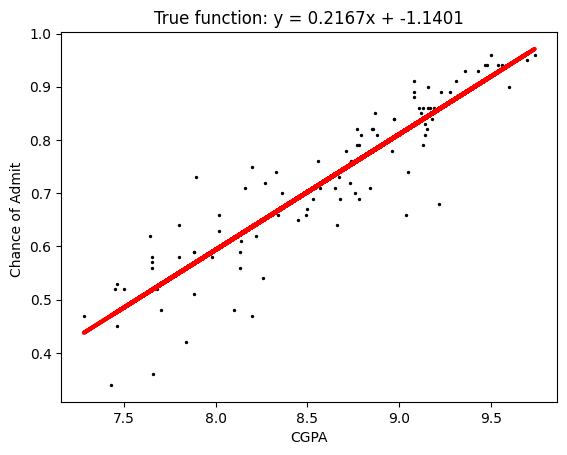

In [ ]:
X = np.array(testing_data['CGPA'])
y = np.array(testing_data['Chance of Admit ']) # Extra space in key 'Chance of Admit'

# Calculate Slope and Intercept
m, b = np.polyfit(X.flatten(), y.flatten(), 1)
equation = f"y = {m:.4f}x + {b:.4f}"

#Plot
plt.scatter(X, y,  color='black',s=2)
plt.xlabel('CGPA')
plt.ylabel('Chance of Admit ')
plt.plot(X, m*X + b, color='red', linewidth=3)
plt.title('True function: ' + equation)

# print the error
error = np.mean((m*X + b - y)**2)
print(f"Error: {error:.4f}")


## Multiple Regression Model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(training_data[['CGPA']], training_data['Chance of Admit '])


LinearRegression()

In [ ]:
# Apply model to the test set
y_pred_test = regr.predict(testing_data[['CGPA']])

Root mean squared error = 0.0622
R-squared = 0.8291


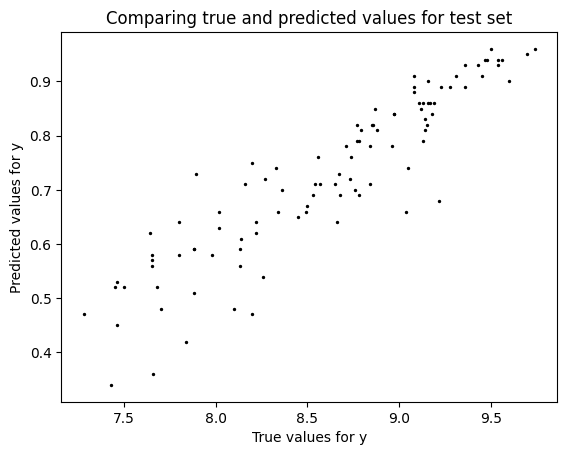

In [ ]:
# Comparing true versus predicted values
plt.scatter(testing_data['CGPA'], testing_data['Chance of Admit '],  color='black',s=2)
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(testing_data['Chance of Admit '], y_pred_test)))
print('R-squared = %.4f' % r2_score(testing_data['Chance of Admit '], y_pred_test))

Slope =  0.20294425986232859
Intercept =  -1.0182042839120313


Text(0, 0.5, 'Chance of Admit ')

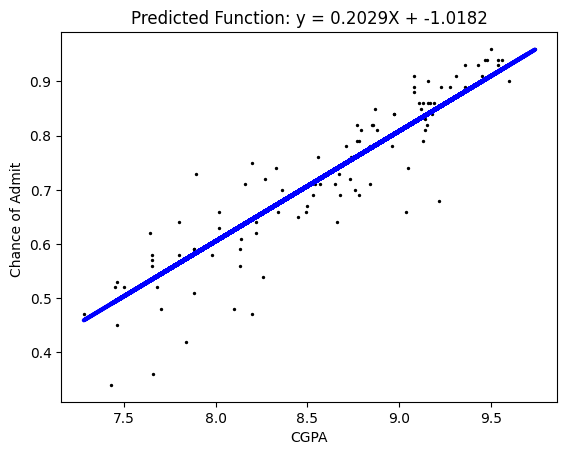

In [ ]:
# Display model parameters
print('Slope = ', regr.coef_[0])
print('Intercept = ', regr.intercept_)### Step 4: Postprocessing

# Plot outputs
plt.scatter(testing_data['CGPA'], testing_data['Chance of Admit '],  color='black',s=2)
plt.plot(testing_data['CGPA'], y_pred_test, color='blue', linewidth=3)
titlestr = 'Predicted Function: y = %.4fX + %.4f' % (regr.coef_[0], regr.intercept_)
plt.title(titlestr)
plt.xlabel('CGPA')
plt.ylabel('Chance of Admit ')

# Analysis

Based on our findings, we can see that as the Cumulative GPA increases, the Chance of admission also increases. In other words, the chance of admission is directly proportional to the CGPA of a student.

9.65    1
8.87    3
8.00    9
8.67    5
8.21    3
       ..
7.57    1
7.21    1
9.27    1
7.81    1
7.69    1
Name: CGPA, Length: 184, dtype: int64

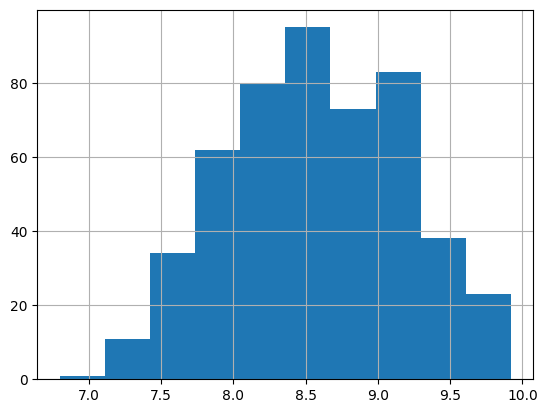

In [ ]:
# Discretize the CGPA column into 3 classes and create classification tree with training data
df['CGPA'].hist(bins=10)
df['CGPA'].value_counts(sort=False)

## Discretize The CGPA into 3 seperate classes - [Low(6.797 - 7.84), Medium(7.84 - 8.88), High(8.88 - 9.92)]


In [ ]:
bins = pd.cut(df['CGPA'],3)
# display bin ranges
bins.value_counts(sort=False)

(6.797, 7.84]     52
(7.84, 8.88]     285
(8.88, 9.92]     163
Name: CGPA, dtype: int64

Low        52
Medium    285
High      163
Name: CGPA, dtype: int64


<Axes: >

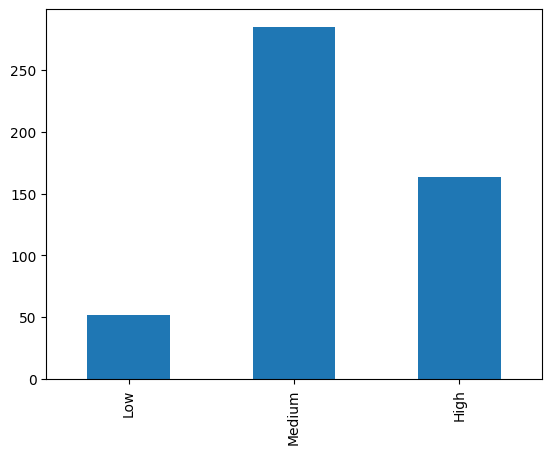

In [ ]:
bins = pd.cut(df['CGPA'],3,labels=['Low','Medium','High'])
print(bins.value_counts(sort=False))
bins.value_counts(sort=False).plot(kind='bar')